<a href="https://colab.research.google.com/github/youssefhassan369/Image_stitching_using_homographs/blob/main/Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [14]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import ndimage, misc
from google.colab.patches import cv2_imshow

#Interpolataion implementaion 

In [15]:
def interpolataion(original_image,rotated_index,scale,H_inv):

    x=np.floor(rotated_index[1]).astype(int)
    x=x*scale
    y=np.floor(rotated_index[0]).astype(int)
    y=y*scale
    original_index=np.matmul(H_inv,(y,x,scale))
    top_left=original_image[int(original_index[1])%len(original_image),int(original_index[0])%len(original_image[0])]



    x=np.ceil(rotated_index[1]).astype(int)
    x=x*scale
    y=np.floor(rotated_index[0]).astype(int)
    y=y*scale
    original_index=np.matmul(H_inv,(y,x,scale))
    top_right=original_image[int(original_index[1])%len(original_image),int(original_index[0])%len(original_image[0])]
    


    x=np.floor(rotated_index[1]).astype(int)
    x=x*scale
    y=np.ceil(rotated_index[0]).astype(int)
    y=y*scale
    original_index=np.matmul(H_inv,(y,x,scale))
    down_right=original_image[int(original_index[1])%len(original_image),int(original_index[0])%len(original_image[0])]



    x=np.ceil(rotated_index[1]).astype(int)
    x=x*scale
    y=np.ceil(rotated_index[0]).astype(int)
    y=y*scale
    original_index=np.matmul(H_inv,(y,x,scale))
    down_left=original_image[int(original_index[1])%len(original_image),int(original_index[0])%len(original_image[0])]


    return top_left,top_right,down_right,down_left

#Stitching Implemtaion

In [29]:
def stitching(first_image,second_image):

	img_reference=cv2.cvtColor(first_image,cv2.COLOR_BGR2GRAY) #Image that will be rotated 
	frame=cv2.cvtColor(second_image,cv2.COLOR_BGR2GRAY) #Fixed Image

	sift = cv2.SIFT_create()
	kp_reference, des_reference = sift.detectAndCompute(img_reference,None)
	kp_frame, des_frame = sift.detectAndCompute(frame,None)
	bf = cv2.BFMatcher()
	matches = bf.knnMatch(des_reference,des_frame, k=2)

	correspondence_reference = []
	correspondence_frame = []
	for m,n in matches:
		if m.distance < 0.5*n.distance:
			correspondence_reference.append(kp_reference[m.queryIdx].pt)
			correspondence_frame.append(kp_frame[m.trainIdx].pt)

	A = np.empty((0,9))
	for i in range(len(correspondence_reference)):
		u,v=correspondence_frame[i]
		x,y=correspondence_reference[i]

		x=np.array([
				   [-x , -y , -1 , 0 ,0 ,0 ,u*x, u*y , u],
				   [0,0,0,-x,-y,-1,v*x,v*y,v]
				   ])

		A = np.vstack( (A,x) )

	u, s, v = linalg.svd(A)
	DOF=np.reshape(v[np.argmin(s)],(3,3))

	img_reference=first_image
	frame=second_image
	final_frame=np.zeros(  (second_image.shape[0]+first_image.shape[0]*2,second_image.shape[1]+first_image.shape[1]*2,3)  ).astype(np.uint8)

	for i in range (img_reference.shape[0]):
		for j in range (img_reference.shape[1]):
				new_cordinates=np.matmul(DOF,(j,i, 1))
				scale=new_cordinates[2] #getting scale to be used for interpolation if needed
				new_cordinates=new_cordinates/new_cordinates[2]
				if (new_cordinates[0].is_integer()==0 or new_cordinates[1].is_integer()==0 ):	#if new pixel cordinates is not a whole number 
					top_left,top_right,down_right,down_left=interpolataion(img_reference,new_cordinates,scale,np.linalg.inv(DOF)) #getting pixels around
		 			
					final_frame[i+int(img_reference.shape[0]),j+int(img_reference.shape[1]),:]=frame[i,j,:]
					final_frame[np.floor(new_cordinates[1]).astype(int)+int(img_reference.shape[0]),np.floor(new_cordinates[0]).astype(int)+int(img_reference.shape[1]),:]=top_left
					final_frame[np.ceil(new_cordinates[1]).astype(int)+int(img_reference.shape[0]),np.floor(new_cordinates[0]).astype(int)+int(img_reference.shape[1]),:]=top_right
					final_frame[np.ceil(new_cordinates[1]).astype(int)+int(img_reference.shape[0]),np.ceil(new_cordinates[0]).astype(int)+int(img_reference.shape[1]),:]=down_right
					final_frame[np.floor(new_cordinates[1]).astype(int)+int(img_reference.shape[0]),np.ceil(new_cordinates[0]).astype(int)+int(img_reference.shape[1]),:]=down_left

				else:		 
					final_frame[i+int(img_reference.shape[0]),j+int(img_reference.shape[1]),:]=frame[i,j,:]
					final_frame[new_cordinates[1]+int(img_reference.shape[0]),new_cordinates[0]+int(img_reference.shape[1]),:]=img_reference[i,j,:]

	xs,ys,zs = np.where(final_frame!=0)
	final_frame = final_frame[min(xs):max(xs)+1,min(ys):max(ys)+1,min(zs):max(zs)+1]
	H,status=cv2.findHomography(np.array(correspondence_reference), np.array(correspondence_frame),cv2.RANSAC, 5.0)
	return final_frame,DOF/DOF[2][2],H

#Test Cases

##Test case 1

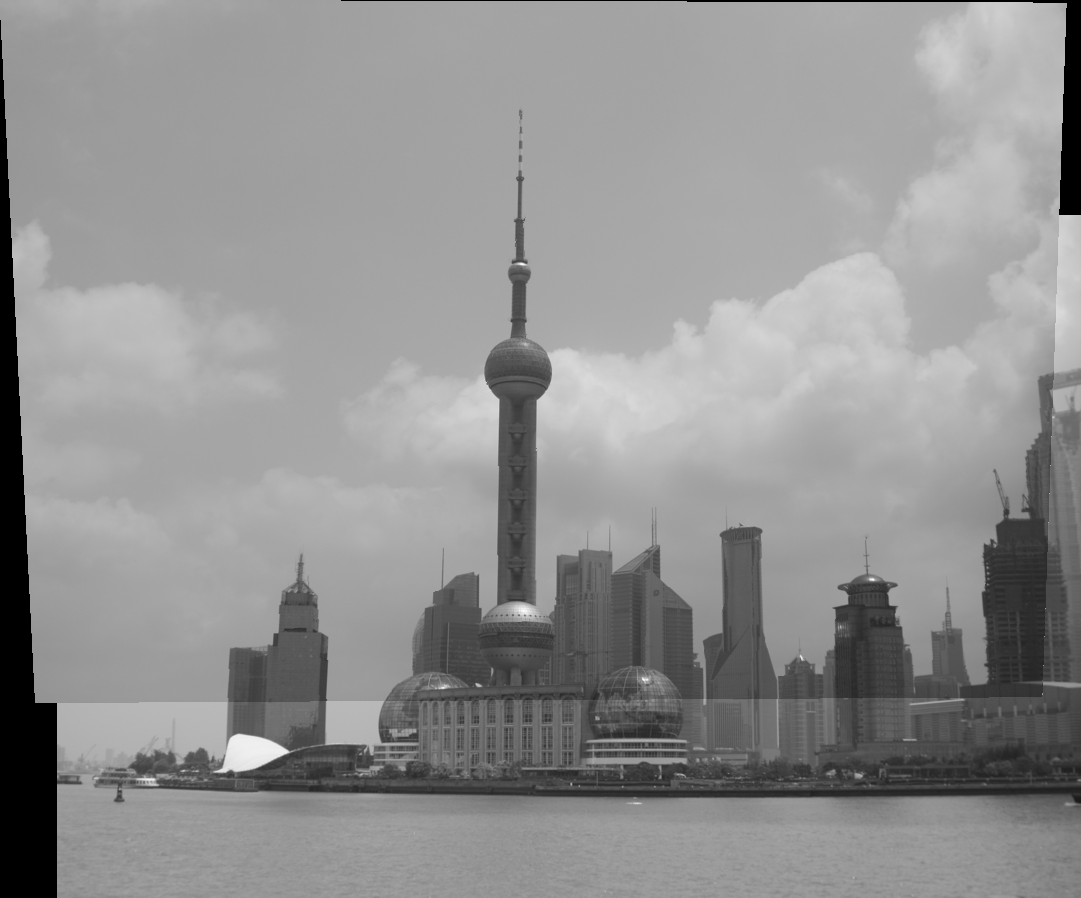

Homography from built-in function
[[ 1.05324230e+00  4.95365671e-02 -5.64334136e+01]
 [-4.37414265e-05  1.07013985e+00 -2.14465062e+02]
 [ 1.26099053e-05  8.65935468e-05  1.00000000e+00]]
---------------------------------
Homography from our implementation
[[ 1.05445818e+00  5.00782833e-02 -5.69577030e+01]
 [ 2.13228006e-04  1.07128365e+00 -2.14981750e+02]
 [ 1.31921639e-05  8.74637393e-05  1.00000000e+00]]


In [34]:
img1=cv2.imread("shanghai-21.png")
img2 = cv2.imread("shanghai-22.png")
result1,DOF1,h1=stitching(img2,img1)
cv2_imshow(result1)
print("Homography from built-in function")
print(h1)
print("---------------------------------")
print("Homography from our implementation")
print(DOF1)

###Stitching third image to result (Bonus)

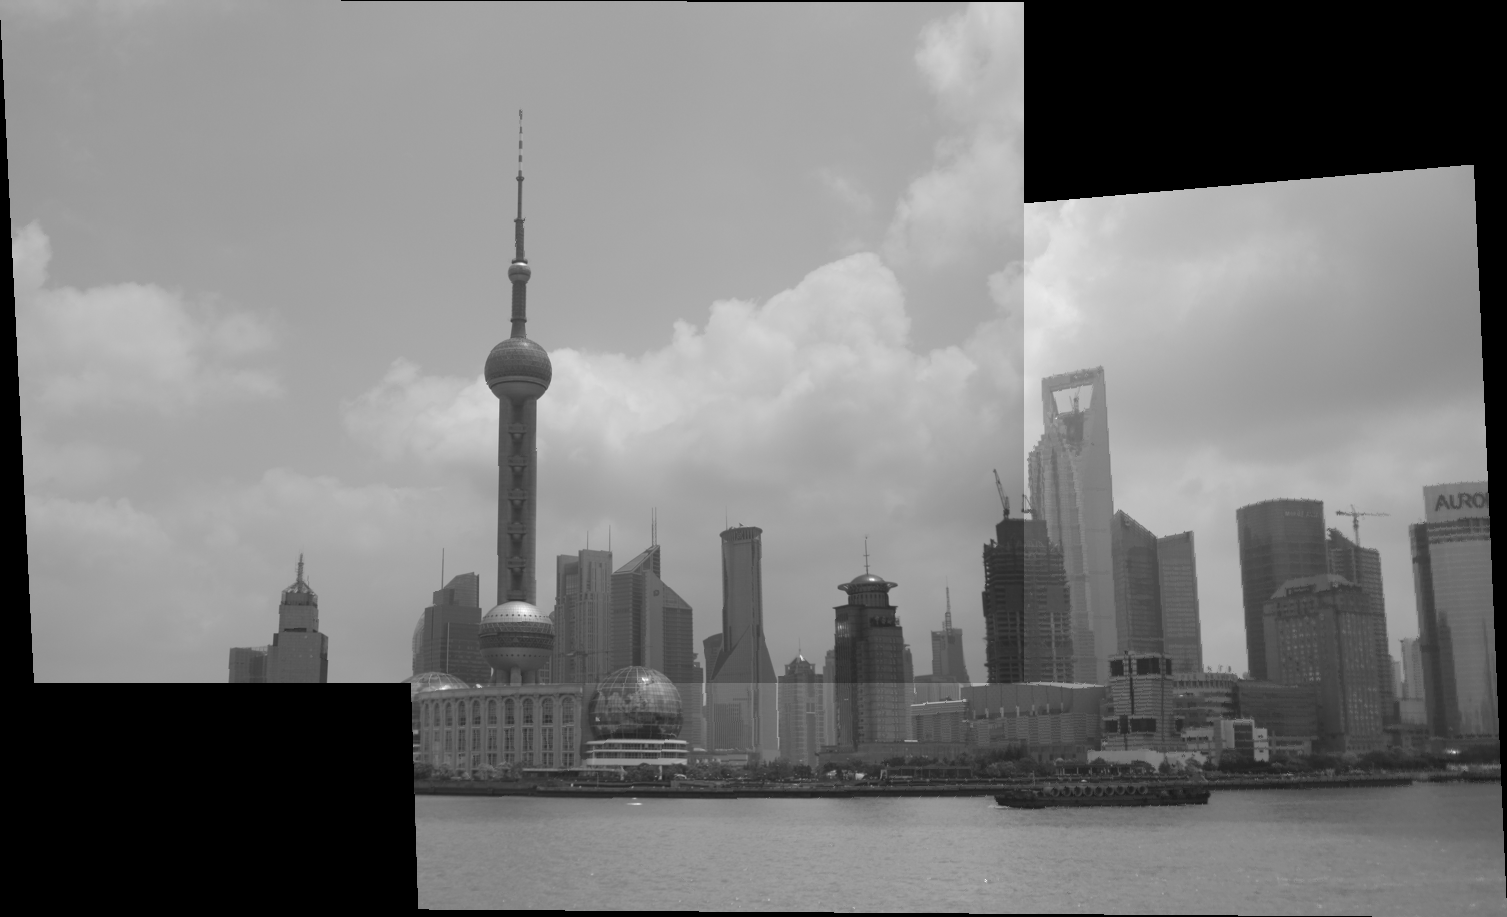

Homography from built-in function
[[ 8.69274680e-01  1.67634685e-02  4.00421118e+02]
 [-1.03037301e-01  9.37401518e-01  2.58930779e+02]
 [-1.15978186e-04 -1.67043720e-05  1.00000000e+00]]
---------------------------------
Homography from our implementation
[[ 8.56989193e-01  2.61769379e-02  3.97752532e+02]
 [-1.12549362e-01  9.43198764e-01  2.57994461e+02]
 [-1.31416455e-04 -1.07641505e-05  1.00000000e+00]]


In [35]:
img3 = cv2.imread("shanghai-23.png")
result2,DOF2,h2=stitching(img3,result1)
cv2_imshow(result2)
print("Homography from built-in function")
print(h2)
print("---------------------------------")
print("Homography from our implementation")
print(DOF2)

##Test Case 2 

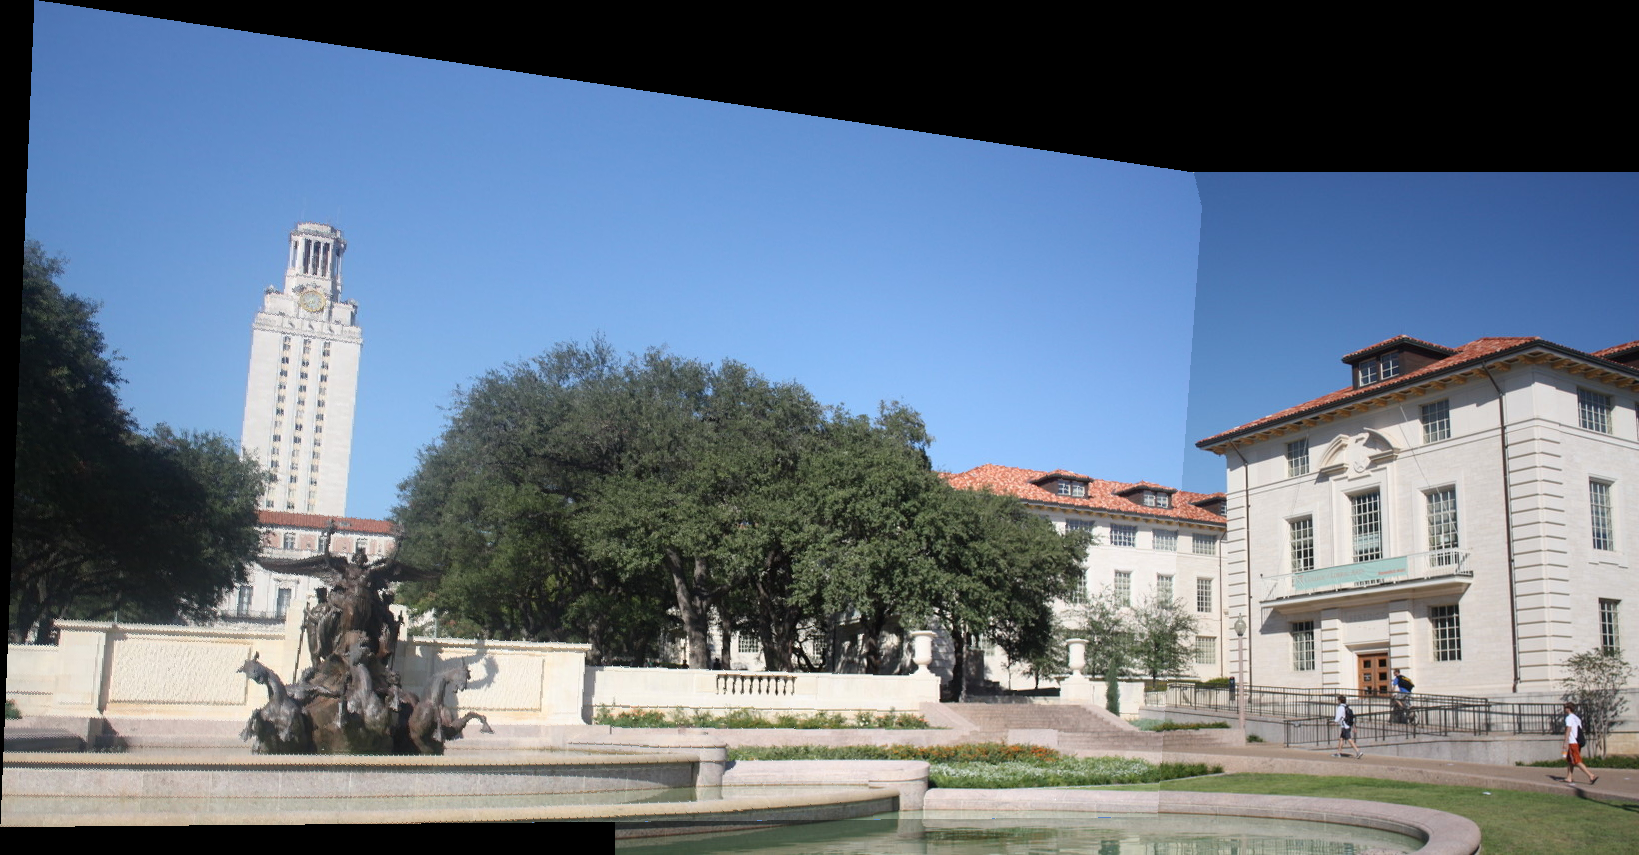

Homography from built-in function
[[ 1.29844370e+00 -7.28812388e-02 -5.74509670e+02]
 [ 1.69257597e-01  1.22127305e+00 -1.68398835e+02]
 [ 2.78210586e-04  2.39738843e-05  1.00000000e+00]]
---------------------------------
Homography from our implementation
[[ 1.30676735e+00 -7.02404829e-02 -5.80077080e+02]
 [ 1.70745568e-01  1.23160231e+00 -1.71514730e+02]
 [ 2.80868462e-04  3.32099825e-05  1.00000000e+00]]


In [36]:
img2 = cv2.imread("image2.jpg")
img1=cv2.imread("image1.jpg")
result,DOF,h=stitching(img2,img1)
cv2_imshow(result)
print("Homography from built-in function")
print(h)
print("---------------------------------")
print("Homography from our implementation")
print(DOF)